In [95]:
from models import *
from utils import *

import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# I. Detecting the digits on the images

<hr>

In [114]:
config_path='config/yolov3.cfg'
weights_path='config/yolov3.weights'
class_path='config/coco.names'
img_size= 416
conf_thres= 0.8
nms_thres= 0.4

# Load model and weights
model = Darknet(config_path, img_size=img_size)
model.load_weights(weights_path)
model.cuda()

model.eval()
classes = utils.load_classes(class_path)
Tensor = torch.cuda.FloatTensor

c:\users\fonse\pythonenvs\venv_lab\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [115]:
def filter_overlap(boxes):
    # boxes (x1, y1, x2, y2, object_conf, class_score, class_pred)
    subset = boxes[(boxes[:,4]>.9) & (boxes[:,5] >.9)] # getting the items whose object confidence and class score are high
    sorted, indices = torch.sort(subset[:,0])
    subset = subset[indices]
    subset_ = torch.zeros(1,7)
    i=0
    while i < len(subset)-1:
        if i == 0:
            subset_ = subset[i]
            i+=1
        else:
            if (subset[i+1][0] - subset[i][0])/(subset[i][2] - subset[i][0]) < .2:
                subset_ = torch.cat((subset_,subset[i+1]),0)
                i+=2
            else:
                subset_ = torch.cat((subset_,subset[i]),0)
                i+=1
    subset_ = subset_.view(-1,7)
    return subset_

In [116]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    
    
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 10, conf_thres, nms_thres)
    return detections[0]

In [117]:
listOfImages = os.listdir('data/water_meter/images/')

def rand_image(debug = False):
    file = 'data/water_meter/images/'+listOfImages[np.random.randint(0,338)]
    if debug == True: print(file)
    return file

In [118]:
def pred(img_path):
    # load image and get detections
    prev_time = time.time()
    img = Image.open(img_path)
    detections = detect_image(img)
    detections = filter_overlap(detections)
    inference_time = datetime.timedelta(seconds=time.time() - prev_time)
    print ('Inference Time: %s' % (inference_time))

    # Get bounding-box colors
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, 20)]

    img = np.array(img)
    plt.figure()
    fig, ax = plt.subplots(1, figsize=(12,9))
    ax.imshow(img)

    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    pred = []
    if detections is not None:
        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        bbox_colors = random.sample(colors, n_cls_preds)
        # browse detections and draw bounding boxes
        for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
            box_h = ((y2 - y1) / unpad_h) * img.shape[0]
            box_w = ((x2 - x1) / unpad_w) * img.shape[1]
            y1 = ((y1 - pad_y // 2) / unpad_h) * img.shape[0]
            x1 = ((x1 - pad_x // 2) / unpad_w) * img.shape[1]
            color = bbox_colors[int(np.where(unique_labels == int(cls_pred))[0])]
            bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(bbox)
            plt.text(x1, y1, s=classes[int(cls_pred)], color='white', verticalalignment='top',
                    bbox={'color': color, 'pad': 0})
            pred.append(cls_pred)
    plt.axis('off')
    plt.title('without filters')
    plt.show()
    
    return detections

data/water_meter/images/id_1035_value_690_387.jpg
Inference Time: 0:00:00.352794


<Figure size 432x288 with 0 Axes>

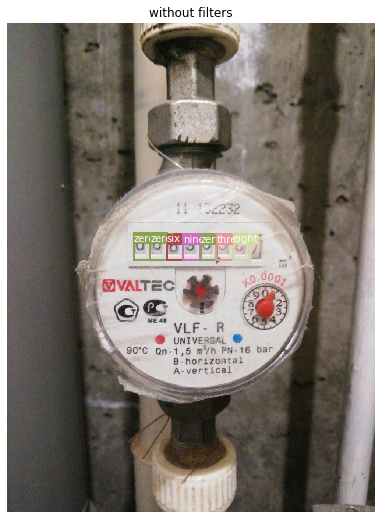

tensor([0., 0., 6., 9., 0., 3., 8.], device='cuda:0')

In [119]:
boxes = pred(rand_image(debug = True))
boxes.shape
boxes[:,6]

Inference Time: 0:00:00.315203


<Figure size 432x288 with 0 Axes>

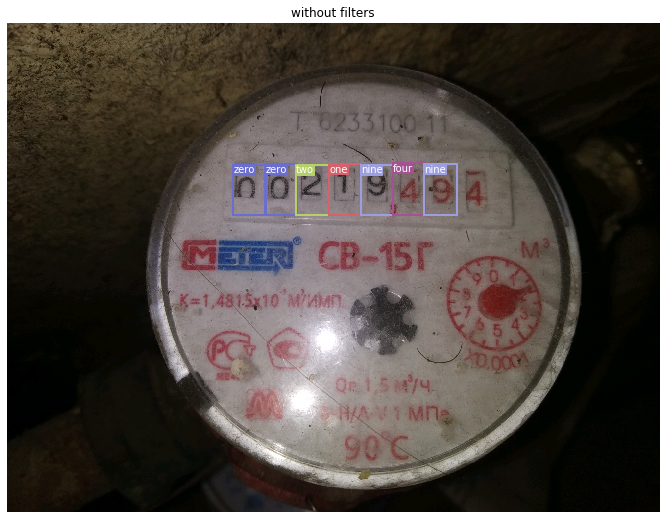

tensor([0., 0., 2., 1., 9., 4., 9.], device='cuda:0')

In [120]:
boxes = pred('data/water_meter/images/id_1062_value_219_494.jpg')
boxes.shape
boxes[:,6]

data/water_meter/images/id_1079_value_281_559.jpg
Inference Time: 0:00:00.473381


<Figure size 432x288 with 0 Axes>

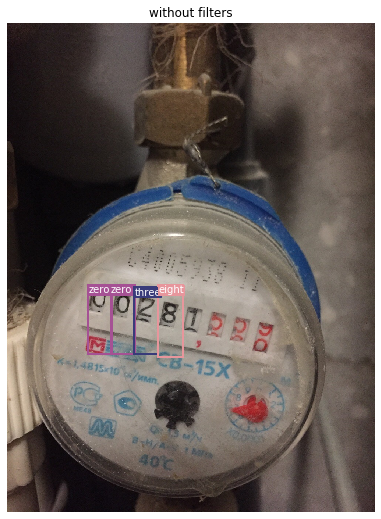

tensor([0., 0., 3., 8.], device='cuda:0')

In [121]:
boxes = pred(rand_image(debug = True))
boxes.shape
boxes[:,6]

data/water_meter/images/id_1059_value_1127_775.jpg
Inference Time: 0:00:00.423866


<Figure size 432x288 with 0 Axes>

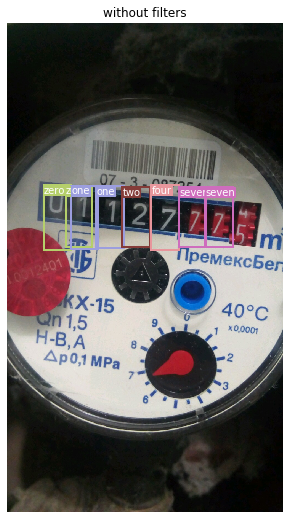

tensor([0., 0., 1., 1., 2., 4., 7., 7.], device='cuda:0')

In [122]:
boxes = pred(rand_image(debug = True))
boxes.shape
boxes[:,6]

# II. Evaluating the accuracy on the test set

<hr>

In [123]:
import pandas as pd

path = 'data/water_meter/val.txt'

df = pd.read_csv(path, header = None, names=['file_path'])

In [124]:
def prediction(img_path):
    # load image and get detections
    img = Image.open(img_path)
    detections = detect_image(img)
    detections = filter_overlap(detections)
    if not detections is None:
        m = ''
        for i in range(len(detections)):
            m = m + str(int(detections[i,6].item()))
    else:
        m ='00000000'

    return m

In [125]:
df.head(5)

,file_path
0,data/water_meter/images/id_1014_value_189_678.jpg
1,data/water_meter/images/id_1027_value_654_785.jpg
2,data/water_meter/images/id_1037_value_136_621.jpg
3,data/water_meter/images/id_1048_value_325_913.jpg
4,data/water_meter/images/id_1059_value_1127_775...


In [126]:
def measumerent(file):
    decode = file.split('/')[-1].split('_')
    if decode[4].split('.')[0] == '0':
        m = decode[3].zfill(5)
    else: 
        m = (decode[3]+ decode[4].split('.')[0].zfill(3)).zfill(8)
    return m

In [127]:
df['measurement'] = df.apply(lambda row: measumerent(row['file_path']), axis=1)
df

,file_path,measurement
0,data/water_meter/images/id_1014_value_189_678.jpg,00189678
1,data/water_meter/images/id_1027_value_654_785.jpg,00654785
2,data/water_meter/images/id_1037_value_136_621.jpg,00136621
3,data/water_meter/images/id_1048_value_325_913.jpg,00325913
4,data/water_meter/images/id_1059_value_1127_775...,01127775
...,...,...
99,data/water_meter/images/id_948_value_349_795.jpg,00349795
100,data/water_meter/images/id_960_value_606_357.jpg,00606357
101,data/water_meter/images/id_970_value_437_807.jpg,00437807
102,data/water_meter/images/id_985_value_108_331.jpg,00108331


In [128]:
df['prediction'] = df.apply(lambda row: prediction(row['file_path']), axis=1)
df

,file_path,measurement,prediction
0,data/water_meter/images/id_1014_value_189_678.jpg,00189678,00089868
1,data/water_meter/images/id_1027_value_654_785.jpg,00654785,00024
2,data/water_meter/images/id_1037_value_136_621.jpg,00136621,0006024
3,data/water_meter/images/id_1048_value_325_913.jpg,00325913,0052991
4,data/water_meter/images/id_1059_value_1127_775...,01127775,00112477
...,...,...,...
99,data/water_meter/images/id_948_value_349_795.jpg,00349795,004975
100,data/water_meter/images/id_960_value_606_357.jpg,00606357,006005
101,data/water_meter/images/id_970_value_437_807.jpg,00437807,00437800
102,data/water_meter/images/id_985_value_108_331.jpg,00108331,0000033


In [131]:
df['overall_row_accuracy'] = df.apply(lambda row: 1 if row['measurement'][:6]==row['prediction'][:6] else 0, axis=1)
df

,file_path,measurement,prediction,overall_row_accuracy
0,data/water_meter/images/id_1014_value_189_678.jpg,00189678,00089868,0
1,data/water_meter/images/id_1027_value_654_785.jpg,00654785,00024,0
2,data/water_meter/images/id_1037_value_136_621.jpg,00136621,0006024,0
3,data/water_meter/images/id_1048_value_325_913.jpg,00325913,0052991,0
4,data/water_meter/images/id_1059_value_1127_775...,01127775,00112477,0
...,...,...,...,...
99,data/water_meter/images/id_948_value_349_795.jpg,00349795,004975,0
100,data/water_meter/images/id_960_value_606_357.jpg,00606357,006005,0
101,data/water_meter/images/id_970_value_437_807.jpg,00437807,00437800,1
102,data/water_meter/images/id_985_value_108_331.jpg,00108331,0000033,0


In [132]:
df[df['overall_row_accuracy']==1].count()

file_path               18
measurement             18
prediction              18
overall_row_accuracy    18
dtype: int64

In [133]:
18/104

0.17307692307692307